# Training a Quantized NN for Modulation Classification
### Modified version of https://github.com/Xilinx/brevitas-radioml-challenge-21/tree/main

In [1]:
# Import some general modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from datetime import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import h5py as h5
#from torchsummary import summary
from sklearn.metrics import classification_report
import brevitas 
import brevitas.quant as quant
import os
import sys

import subprocess

In [5]:
# Using cuda 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

Using GPU cuda


# The RadioML 2021 Dataset <a id='load_dataset'></a>

The dataset comes in hdf5 format and exhibits the following structure:
- 27 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2.875.392 frames in total
- Value is in int8 [-128, 127]



In [17]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

True

In [18]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        # print(np.unique(self.snr))
        # print(self.data.shape)
        # print(np.min(self.data),'   ',np.max(self.data),'  ',self.data.dtype)
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB, with step of 2 --> 26 snrs

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2021)

        train_indices = []
        test_indices = []
        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 26)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                #4096 is the number of frames per modulation-snr pair combination. 2875392 / (27*26) = 4096
                start_idx = 26*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_21_dataset(dataset_path)

Modulation: 8FSK, SNR: 30.0 dB, Index: 2871419


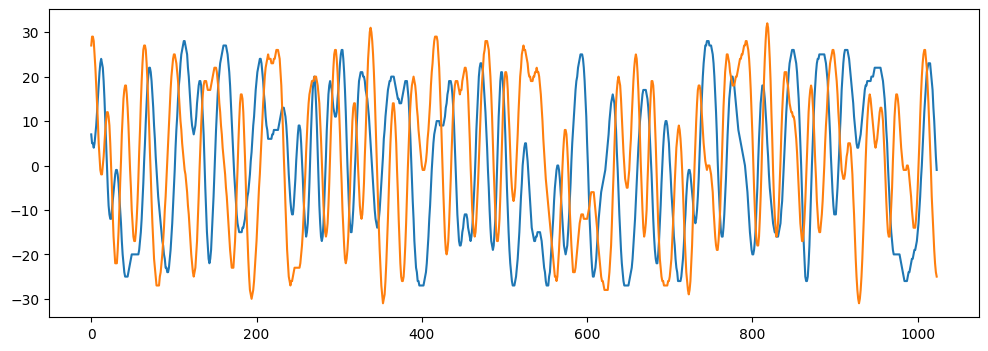

In [19]:
# Inspect a frame
mod = 26 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))

# Define the QNN Model <a id='define_model'></a>

<div>
<img align="right" width="274" height="418" src="attachment:VGG10_small.png">
</div>

As a simple example, we will create a quantized version of the "VGG10" CNN architecture proposed by the dataset authors in [Over-the-Air Deep Learning Based Radio Signal Classification](https://arxiv.org/pdf/1712.04578.pdf).

Quantizing a sequential pytorch model is straightforward with Brevitas. Relevant `torch.nn` layers are simply replaced by their `brevitas.nn` counterparts, which add customizable input, output, or parameter quantization. Regular Torch layers, especially those that are invariant to quantization (e.g. BatchNorm or MaxPool), can be mixed and matched with Brevitas layers.

As a baseline, we apply 8-bit quantization to the activations and weights of every layer, except for the final classification output. The input data is quantized to 8 bits with a dedicated quantization layer. Instead of letting Brevitas determine the quantization scale automatically, we set a fixed quantization range (-2.0, 2.0) based on analysis of the whole dataset. Except for two outlier classes (both single-sideband (SSB) modulations), the vast majority of samples (98.3%) at +30 dB fall within this range and will thus not be clipped.

For more information on Brevitas you can turn to these resources:
- [GitHub repository](https://github.com/Xilinx/brevitas)
- [Tutorial notebooks](https://github.com/Xilinx/brevitas/tree/master/notebooks)
- [Example models](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples)
- Public discussion in the [Brevitas Gitter channel](https://gitter.im/xilinx-brevitas/community)

In [20]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import Int8Bias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Adjustable hyperparameters
input_bits = 8
a_bits = 8
w_bits = 8
filters_conv = 64
filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    #Using 8 bits
    bit_width = input_bits
    #Converting from int8 [-127,128] to finn-float32 [-127.0,128.0]
    #Since our dataset is already quantized before going through the model, this would only convert the datatype, the values would be the same
    min_val = -127.0
    max_val = 128.0
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

model_class = nn.Sequential(
    # Input quantization layer
    qnn.QuantHardTanh(act_quant=InputQuantizer),

    qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits,bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),
    
    nn.Flatten(),

    qnn.QuantLinear(filters_conv*8, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits),

    qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

    qnn.QuantLinear(filters_dense, 27, weight_bit_width=w_bits, bias=True, bias_quant=Int8Bias),
)
model=model_class

import torchinfo
print(torchinfo.summary(model_class,input_size=(1,2,1024)))

Layer (type:depth-idx)                                            Output Shape              Param #
Sequential                                                        [1, 27]                   --
├─QuantHardTanh: 1-1                                              [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-1                             [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-2                             [1, 2, 1024]              --
│    │    └─FusedActivationQuantProxy: 3-1                        [1, 2, 1024]              --
├─QuantReLU: 1-50                                                 --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-59                            --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-34                       --                        (recursive)
├─QuantHardTanh: 1-3                                              --                        --
│    └─ActQuantPro

# Train the QNN from Scratch <a id='train_model'></a>
<span style="color:red">Even with GPU acceleration, training will take multiple minutes per epoch!<br>You can skip this section and load a pre-trained model instead: [Load Pre-Trained Parameters](#load_trained_model)</span>

First, we define basic train and test functions, which will be called for each training epoch. Training itself follows the usual Pytorch procedures, while Brevitas handles all quantization-specifics automatically in the background.

In [21]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Training Batches", leave=False):   
        #if gpu is not None:
        inputs = inputs.to('cuda')
        target = target.to('cuda')
                
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in tqdm(test_loader, desc="Testing Batches", leave=False):
            #if gpu is not None:
            inputs = inputs.to('cuda')
            target = target.to('cuda')
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Now we can start the training loop for a number of epochs.

If you run into VRAM limitations of your system, it might help to decrease the `batch_size` and initial learning rate accordingly. To keep this notebook's resource footprint small, we do not pre-load the whole dataset into DRAM. You should adjust your own training code to take advantage of multiprocessing and available memory for maximum performance.

In [ ]:
batch_size = 1024
num_epochs = 20

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

#if gpu is not None:
model = model.to('cuda')

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
#if gpu is not None:
criterion = criterion.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

running_loss = []
running_test_acc = []
Path("27ml_rf").mkdir(exist_ok=True)
chpt_path="27ml_rf/model_w8a8_trained.pth"
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        print('training')
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        print('testing')
        test_acc = test(model, data_loader_test)
        print("Epoch %d: Training loss = %f, test accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))
        torch.save(model.state_dict(), chpt_path)
        print(f'Model checkpoint is saved in {chpt_path}')
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()

In [ ]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

In [ ]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [ ]:
# Save the trained parameters to disk
Path("27ml_rf").mkdir(exist_ok=True)
torch.save(model.state_dict(), "27ml_rf/model_w8a8_trained.pth")

# Load a Trained Model <a id='load_trained_model'></a>

In [ ]:
model=model_class
model.load_state_dict(torch.load("27ml_rf/model_trained.pth"))
model.to('cuda')

# Evaluate the Accuracy <a id='evaluate_accuracy'></a>
The following cells visualize the test accuracy across different modulations and signal-to-noise ratios. Submissions for this problem statement must reach an overall accuracy of at least **56.0%**, so this should give you an idea what makes up this figure.

In [24]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_21_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [25]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        #if gpu is not None:
        inputs = inputs.cuda()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Overall Accuracy across all SNRs: 0.623324


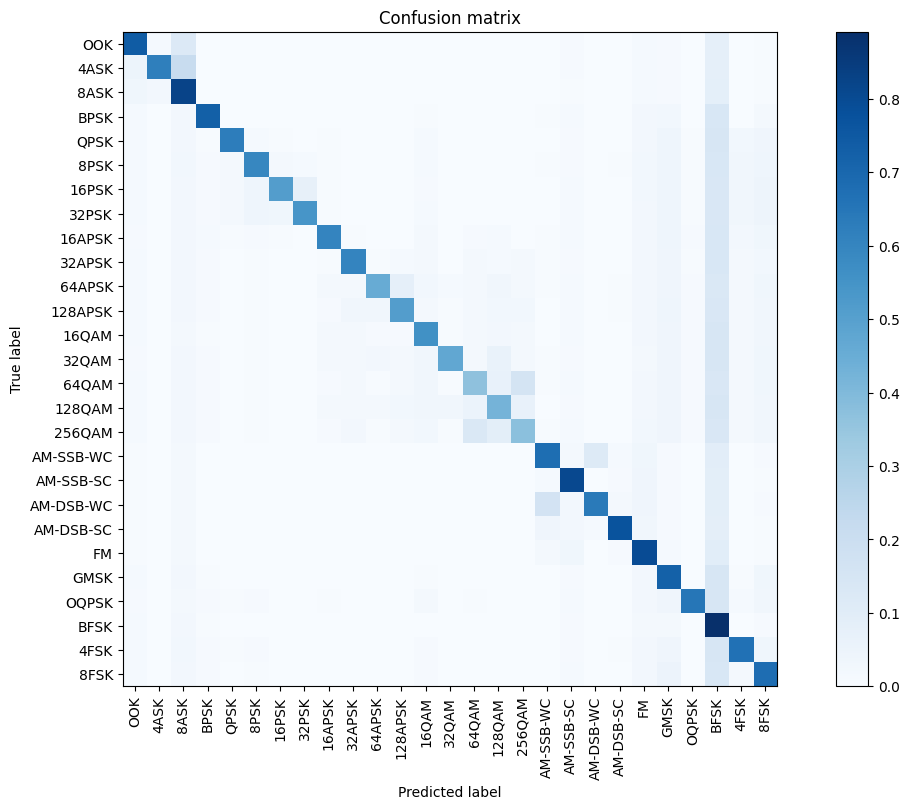

In [30]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

/tmp/ipykernel_182/3267716818.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221+plot)


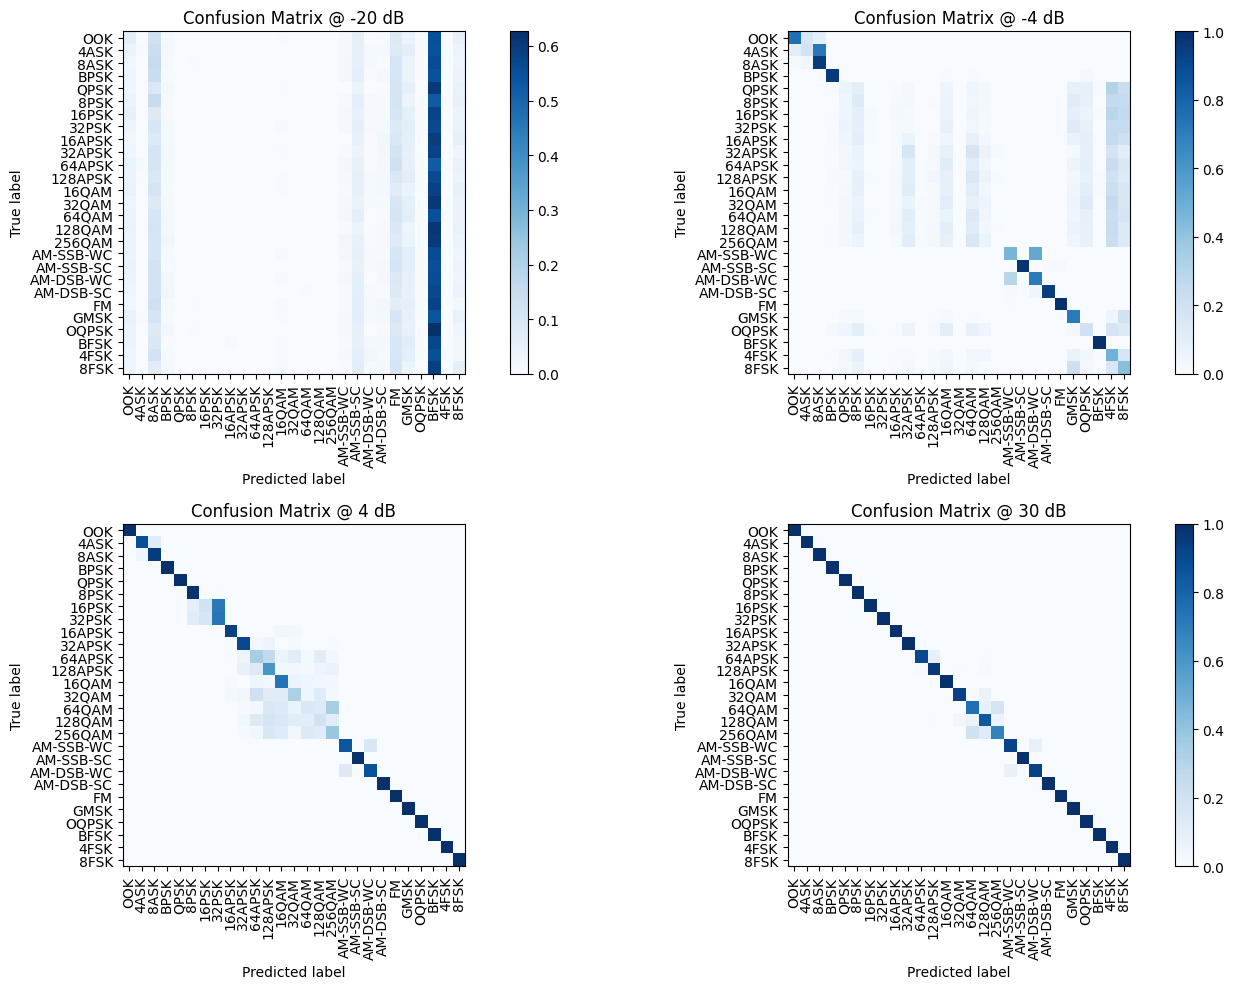

In [27]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

Accuracy @ highest SNR (+30 dB): 0.960072
Accuracy overall: 0.623324


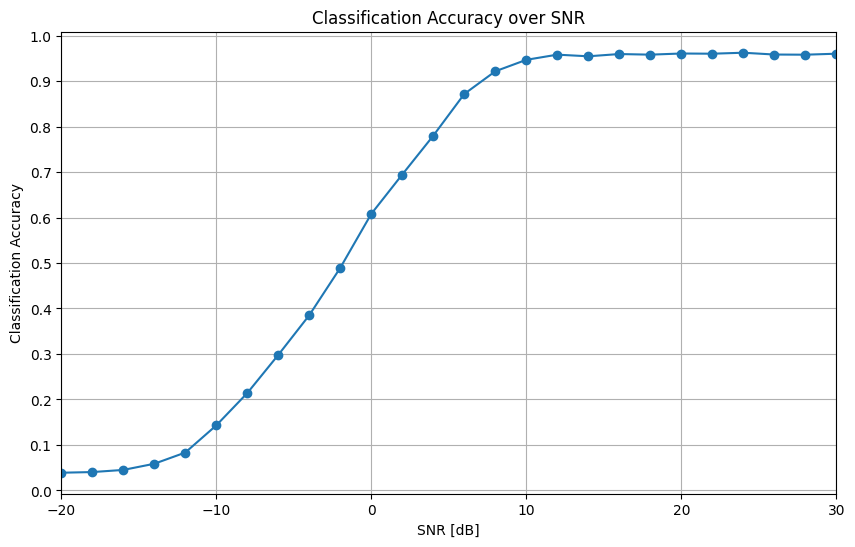

In [28]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

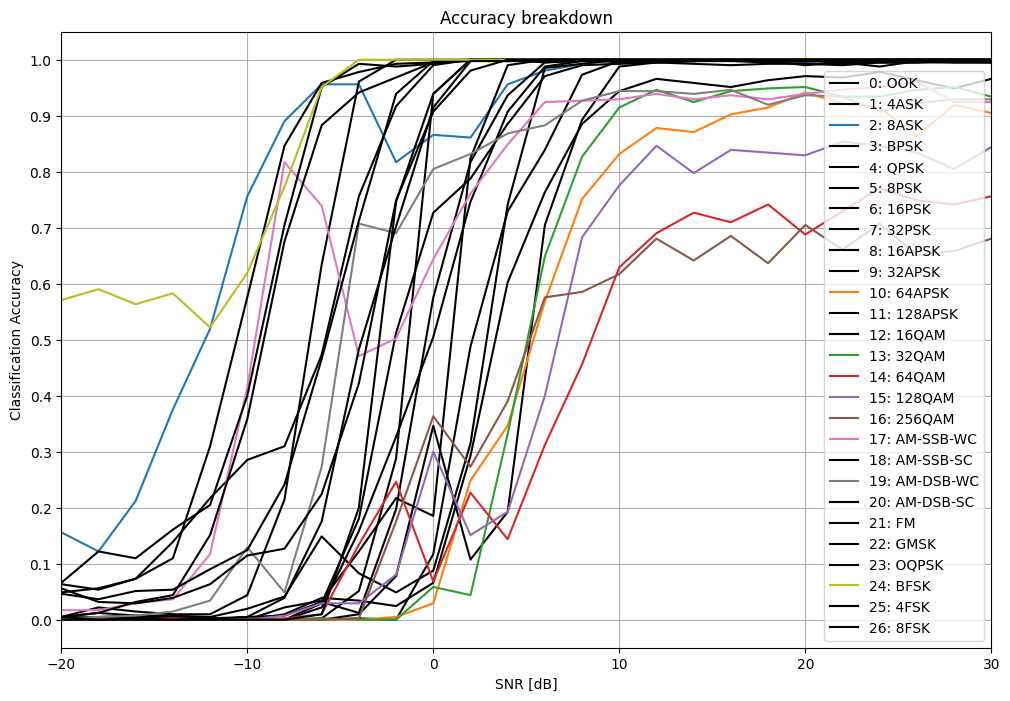

In [29]:
# Plot accuracy per modulation
accs = []
for mod in range((dataset.num_classes)):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(dataset.num_classes):
    if accs[mod][-1] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();

In [ ]:
import torch
import onnx
from brevitas.export import export_qonnx,export_brevitas_onnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.util.cleanup import cleanup_model
import os 
import onnx



Path("27ml_rf/models").mkdir(exist_ok=True)
model=model_class
model.load_state_dict(torch.load("27ml_rf/model_trained.pth"))
model.to('cuda')

model.eval()
build_dir="27ml_rf/models"
export_path=f"{build_dir}/radio_27ml_export.onnx"
export_qonnx(model.to('cuda'), torch.randn(1, 2, 1024).to('cuda'), export_path=export_path);
#export_brevitas_onnx(model.cpu(),torch.randn(1, 2, 1024),export_path=export_path)

## Network Surgery to remove preprocessing node

This network surgery only apply the model above. In case the model is changed, the code below should be modified.
The goal is to remove the first multithreshold node that is responsible for quantizing inputs.

For more information on network surgery for different architechture:
https://github.com/Xilinx/finn/discussions/420

In [ ]:
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.insert_topk import InsertTopK
from qonnx.transformation.general import (
    ConvertSubToAdd,
    ConvertDivToMul,
    GiveReadableTensorNames,
    GiveUniqueNodeNames,
    SortGraph,
    RemoveUnusedTensors,
    GiveUniqueParameterTensors,
    RemoveStaticGraphInputs,
    ApplyConfig,
)
import onnx
from onnx import TensorProto, helper
from qonnx.core.datatype import DataType


#Main goal is to skip the first multithreshold node.
#The first multithreshold node is the quantizing data node.
#Because on FPGA we will preprocess the data before forwarding through model, 
#we will remove the first multithreshold node.
model = ModelWrapper(export_path)
model = model.transform(ConvertQONNXtoFINN())
model.save(f"{build_dir}/radio_27ml_finn.onnx")
# tidy up
finn_model = ModelWrapper(f"{build_dir}/radio_27ml_finn.onnx")

finn_model = finn_model.transform(InferShapes())
finn_model = finn_model.transform(InferDataTypes())
finn_model = finn_model.transform(GiveUniqueNodeNames())
finn_model = finn_model.transform(GiveReadableTensorNames())
finn_model.cleanup()

# extract input quantization thresholds for sw-based quantization
# (in case they were not fixed before training)
input_mt_node = finn_model.get_nodes_by_op_type("MultiThreshold")[0]
input_mt_thresholds = finn_model.get_initializer(input_mt_node.input[1])
print("input quant thresholds")
print(input_mt_thresholds)

# preprocessing: remove input reshape/quantization from graph
new_input_node = finn_model.get_nodes_by_op_type("Conv")[0]   # <---- Change this to the name of the node that has its input node the new desired input graph node.
new_input_tensor = finn_model.get_tensor_valueinfo(new_input_node.input[0]) #<--- Get the input node that lead to Conv node or whatever node you just changed above
old_input_tensor = finn_model.graph.input[0]  # <--- Get the current starting node 
finn_model.graph.input.remove(old_input_tensor) #<--- Remove the current starting node
finn_model.graph.input.append(new_input_tensor) #<--- Make the [Node before the Conv node] the starting node
new_input_index = finn_model.get_node_index(new_input_node)
del finn_model.graph.node[0:new_input_index] #<--- Delete every node before the new starting node

#We dont have softmax node but still run it anyway
# postprocessing: remove final softmax node from training
softmax_node = finn_model.graph.node[-1]
softmax_in_tensor = finn_model.get_tensor_valueinfo(softmax_node.input[0])
softmax_out_tensor = finn_model.get_tensor_valueinfo(softmax_node.output[0])
finn_model.graph.output.remove(softmax_out_tensor)
finn_model.graph.output.append(softmax_in_tensor)
finn_model.graph.node.remove(softmax_node)

# remove redundant value_info for primary input/output
# othwerwise, newer FINN versions will not accept the model
if finn_model.graph.input[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.input[0])
if finn_model.graph.output[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.output[0])

# insert topK node in place of the final softmax node
# topK plays similar role to softmax
# k=1 means it pick only 1 class with highest predictions value
finn_model = finn_model.transform(InsertTopK(k=1))

# manually set input datatype (not done by brevitas yet)
finnonnx_in_tensor_name = finn_model.graph.input[0].name
finnonnx_model_in_shape = finn_model.get_tensor_shape(finnonnx_in_tensor_name)
finn_model.set_tensor_datatype(finnonnx_in_tensor_name, DataType["INT8"])
print("Input tensor name: %s" % finnonnx_in_tensor_name)
print("Input tensor shape: %s" % str(finnonnx_model_in_shape))
print("Input tensor datatype: %s" % str(finn_model.get_tensor_datatype(finnonnx_in_tensor_name)))

# save modified model that is now ready for the FINN compiler
finn_model.save(f"{build_dir}/radio_27ml_tidy.onnx")
print("Modified FINN-ready model saved to %s" % f"{build_dir}/radio_27ml_tidy.onnx")

# Export driver bitfile to be loaded on FPGA
Modified version of https://github.com/Xilinx/finn-examples/blob/main/finn_examples/notebooks/5_radioml_with_cnns.ipynb

In [ ]:
# Copyright (c) 2020, Xilinx
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.
#
# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.
#
# * Neither the name of FINN nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
from finn.util.basic import alveo_default_platform
# Import custom steps.py
from custom_steps import step_pre_streamline, step_convert_final_layers, step_custom_fifo

import os
import shutil
import os
import glob
import shutil
from pathlib import Path

build_dir="27ml_rf/models"
finn_build_dir=os.getcwd()+'/tmp/'
final_output_dir="output/"
Path(finn_build_dir).mkdir(exist_ok=True)
Path(final_output_dir).mkdir(exist_ok=True)
print(f'temp files will be built in {finn_build_dir}')

os.environ["FINN_BUILD_DIR"]=finn_build_dir

print(f'removing old temp files in {finn_build_dir}')
files = glob.glob(f'{finn_build_dir}*')
for f in files:
    if os.path.isdir(f):
        shutil.rmtree(f)
    elif os.path.isfile(f):
        os.remove(f)


print(f'output will be generated in {final_output_dir}')
"--------------------------------------------------------------------"
model_name = "radio_27ml_w8a8_tidy"
#Get the tidy.onnx model
model_file = f"{build_dir}/%s.onnx" % model_name

# which platforms to build the networks for
zynq_platforms = ["ZCU104"]
alveo_platforms = []
platforms_to_build = zynq_platforms + alveo_platforms


# determine which shell flow to use for a given platform
def platform_to_shell(platform):
    if platform in zynq_platforms:
        return build_cfg.ShellFlowType.VIVADO_ZYNQ
    elif platform in alveo_platforms:
        return build_cfg.ShellFlowType.VITIS_ALVEO
    else:
        raise Exception("Unknown platform, can't determine ShellFlowType")


# select target clock frequency
def select_clk_period(platform):
    return 4.0
    #return 5.0

from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType

# assemble build flow from custom and pre-existing steps
def select_build_steps(platform):
    return [
        "step_tidy_up",
        step_pre_streamline,
        "step_streamline",
        "step_convert_to_hw",
        step_convert_final_layers,
        "step_create_dataflow_partition",
        "step_specialize_layers",
        "step_target_fps_parallelization",
        "step_apply_folding_config",
        "step_minimize_bit_width",
        "step_generate_estimate_reports",
        "step_hw_codegen",
        "step_hw_ipgen",
        "step_set_fifo_depths",
        "step_create_stitched_ip",
        "step_measure_rtlsim_performance",
        "step_out_of_context_synthesis",
        "step_synthesize_bitfile",
        "step_make_pynq_driver",
        "step_deployment_package",
    ]


# create a release dir, used for finn-examples release packaging
os.makedirs("release", exist_ok=True)

for platform_name in platforms_to_build:
    shell_flow_type = platform_to_shell(platform_name)
    if shell_flow_type == build_cfg.ShellFlowType.VITIS_ALVEO:
        vitis_platform = alveo_default_platform[platform_name]
        # for Alveo, use the Vitis platform name as the release name
        # e.g. xilinx_u250_xdma_201830_2
        release_platform_name = vitis_platform
    else:
        vitis_platform = None
        # for Zynq, use the board name as the release name
        # e.g. ZCU104
        release_platform_name = platform_name
    platform_dir = "release/%s" % release_platform_name
    os.makedirs(platform_dir, exist_ok=True)

    cfg = build_cfg.DataflowBuildConfig(
        steps=select_build_steps(platform_name),
        output_dir=final_output_dir+"output_%s_%s" % (model_name, release_platform_name),
        synth_clk_period_ns=select_clk_period(platform_name),
        target_fps=4600,
        board=platform_name,
        shell_flow_type=shell_flow_type,
        vitis_platform=vitis_platform,
        split_large_fifos=True,
        standalone_thresholds=True,
        # enable extra performance optimizations (physopt)
        vitis_opt_strategy=build_cfg.VitisOptStrategyCfg.PERFORMANCE_BEST,
        generate_outputs=[
            build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
            build_cfg.DataflowOutputType.STITCHED_IP,
            # build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
            build_cfg.DataflowOutputType.BITFILE,
            build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
            build_cfg.DataflowOutputType.PYNQ_DRIVER,
        ],
        
    )
    build.build_dataflow_cfg(model_file, cfg)

    # copy bitfiles and runtime weights into release dir if found
    bitfile_gen_dir = cfg.output_dir + "/bitfile"
    files_to_check_and_copy = [
        "finn-accel.bit",
        "finn-accel.hwh",
        "finn-accel.xclbin",
    ]
    for f in files_to_check_and_copy:
        src_file = bitfile_gen_dir + "/" + f
        dst_file = platform_dir + "/" + f.replace("finn-accel", model_name)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

    weight_gen_dir = cfg.output_dir + "/driver/runtime_weights"
    weight_dst_dir = platform_dir + "/%s_runtime_weights" % model_name
    if os.path.isdir(weight_gen_dir):
        weight_files = os.listdir(weight_gen_dir)
        if weight_files:
            shutil.copytree(weight_gen_dir, weight_dst_dir)

# VIVADO analysis
Ensure you keep the latest generated files in the ```/tmp``` directory

For analysis on VIVADO, checking flip flops, LUTs, ..., you can check under ```output.../report/post_synth_resources.json```
https://github.com/Xilinx/finn/discussions/851

To get hardware layout, you can run implementation on VIVADO with directory ```output.../stitched_ip/```
https://github.com/Xilinx/finn/discussions/1148

# On the FPGA

After the driver and bit file is generated, the deployment package should be generated under the directory ```output_..._ZCU104```, which is also mentioned above in the build steps output

Inside ```deploy/```, copy all contents in ```driver/``` and ```bitfile/``` as well as a custom verification jupyter notebook ```radio-finn/verification_on_FPGA.ipynb``` into a zip file which can be then copied onto the FPGA. 

